# **<center>SDSC3006 Lab : Deep Learning</center>**

TA : Nathanael Tepakbong (Nath)  
Email : ntepakbo-c@my.cityu.edu.hk  
Source material : https://www.statlearning.com/

**Warning :** This notebook relies heavily on the use of the ``torch`` library to build and train neural networks. There might be many dependencies clashes if you're trying to install it on your personal device for your first time. Hence it is heavily recommended to either dedicate a specific ``conda`` environment to this notebook or simply run it on Colab.

### Importing the necessary packages :

In [1]:
#run this line to install ISLP along with other dependencies

#!pip install sklearn ISLP==0.3.19 numpy torchinfo pytorch-lightning==1.8.4

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


We import the usual required packages/libraries :

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import (train_test_split, GridSearchCV)

And the ``torch``-specific ones :

In [3]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

In [4]:
from torchmetrics import (MeanAbsoluteError, R2Score)
from torchinfo import summary
from torchvision.io import read_image

In [5]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [6]:
from pytorch_lightning.utilities.seed import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True , warn_only=True)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/seed.py:48: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v1.10.0. Please use `lightning_lite.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
INFO:lightning_lite.utilities.seed:Global seed set to 0


In [7]:
from ISLP.torch import (SimpleDataModule, SimpleModule, ErrorTracker,
                        rec_num_workers)
from ISLP.torch.imdb import (load_lookup, load_tensor, load_sparse,
                             load_sequential)

##Preliminary - Visualizing Neural Networks

We define a function that will help us visualize Fully Connected Neural Network architectures. This will help us build intuition later.

In [8]:
from matplotlib import pyplot
from math import cos, sin, atan


class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        pyplot.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw( self.neuron_radius )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        pyplot.figure()
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i )
        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title( 'Neural Network architecture', fontsize=15 )
        pyplot.show()

class DrawNN():
    def __init__( self, neural_network ):
        self.neural_network = neural_network

    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw()

Here is an example :

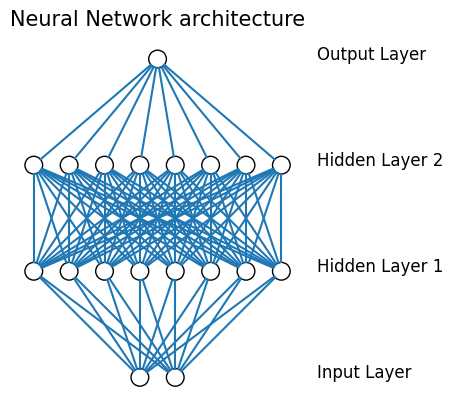

In [9]:
network = DrawNN([2,8,8,1])
network.draw()

##I - Regression : Single Layer Network on ``Hitters`` data

For this first example, we're going to use a single layer Neural Network to perform regression on the ``Hitters`` dataset, which we've already used in previous labs.  

For comparison purposes, we're going to fit two linear models to the same dataset and compare the relative performances. Our evaluation criterion will be given by the Mean Absolute Error (MAE) :
$$MAE(y,\hat y) := \frac1n\sum_{i=1}^n|y_i-\hat y_i| $$

We start by loading the dataset :

In [10]:
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]

Next, we set up the matrix model and split the data into training and validation using the usual ``sklearn`` machinery.

In [11]:
model = MS(Hitters.columns.drop('Salary'), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters['Salary'].to_numpy()

(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y,
                                                      test_size=1/3,
                                                      random_state=1)

### Linear Models :
As announced, we will first fit a standard Linear Regression as well as a Lasso regression to this dataset in order to compare their performance to that of a Neural Network.

####Standard Linear Regression

The fitting and evaluation of a standard linear model can be done very straightforwardly with the ``sklearn`` pipeline :

In [12]:
hit_lm = LinearRegression().fit(X_train , Y_train)
Yhat_test = hit_lm.predict(X_test)
np.abs(Yhat_test - Y_test).mean()

259.7152883314631

####Lasso Regression :

We will now fit a Lasso model to the ``Hitters`` data. As usual, we will use cross-validation to chose the best regularization parameter $\lambda$. However, since our criterion is the MAE, and the ``sklearn`` built-in tool only works for the MSE, we need to tweak the code from previous labs a little bit.

In [13]:
scaler = StandardScaler(with_mean=True , with_std=True)
lasso = Lasso(warm_start=True , max_iter =30000)
standard_lasso = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])

In [14]:
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
param_grid = {'alpha': np.exp(np.linspace(0, np.log(0.01), 100))* lam_max}

In [15]:
cv = KFold(10, shuffle=True, random_state=1)
grid = GridSearchCV(lasso, param_grid, cv=cv,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Lasso(max_iter=30000, warm_start=True),
             param_grid={'alpha': array([255.65755026, 244.03752004, 232.94563812, 222.35789935,
       212.25138966, 202.60423642, 193.39556119, 184.60543446,
       176.21483255, 168.20559645, 160.5603925 , 153.26267486,
       146.29664975, 139.64724123, 133.3000586 , 127.24136521,
       121.45...
        10.81237873,  10.32093943,   9.8518368 ,   9.40405561,
         8.97662677,   8.56862523,   8.17916799,   7.80741218,
         7.45255325,   7.1138232 ,   6.79048896,   6.48185076,
         6.18724064,   5.906021  ,   5.63758323,   5.38134637,
         5.13675587,   4.90328239,   4.68042064,   4.4676883 ,
         4.26462497,   4.07079118,   3.88576744,   3.70915331,
         3.54056657,   3.37964236,   3.2260324 ,   3.07940424,
         2.93944057,   2.80583846,   2.67830877,   2.5565755 ])},
             scoring='neg_mean_absolute_error')

Now that we have evaluated the lasso model over our range of values for $\lambda$, we can evaluate the best estimator on our validation data.

In [16]:
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean()

257.23820107995

There is not much variation with the simple linear regression, however the result can vary depending on the random splits of the data we've used for the cross validation.  

**Task :** rerun the above computations with different random seeds and comment on the variability of the result.

####Specifying a Neural Network : Classes and Inheritance

We are now ready to introduce the stars of the show : deep neural networks ! To specify a neural network model, we first need to define what architecture we want to use, and we will then use gradient descent to find the best possible weights for the chosen architecture. This is done through the ``pytorch`` API which provides a fairly intuitive way to do so, as we will see.

In [17]:
class HittersModel(nn.Module):

    def __init__(self , input_size):
        super(HittersModel , self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
        nn.Linear(input_size , 50),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(50, 1))

    def forward(self , x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

The ``class`` statement identifies the code chunk as a declaration for a class
``HittersModel`` that inherits from the base class ``nn.Module``. This base class is ubiquitous in ``torch`` and represents the mappings in the neural networks.  
Indented beneath the ``class`` statement are the methods of this class: in
this case ``__init__`` and ``forward``. The ``__init__`` method is called when an instance of the class is created as in the cell below. In the methods, ``self`` always refers to an instance of the class. In the ``__init__`` method, we have attached two objects to ``self`` as attributes: ``flatten`` and sequential. These are used in the ``forward`` method to describe the map that this module implements.

There is one additional line in the ``__init__`` method, which is a call to
``super()``. This function allows subclasses (i.e. ``HittersModel``) to access methods of the class they inherit from. For example, the class ``nn.Module`` has its own ``__init__`` method, which is different from the ``HittersModel.__init__()`` method we’ve written above. Using ``super()`` allows us to call the method of the base class.  

For torch models, we will always be making this ``super()``
call as it is necessary for the model to be properly interpreted by ``torch``.
The object ``nn.Module`` has more methods than simply ``__init__`` and ``forward``. These methods are directly accessible to ``HittersModel`` instances because of this inheritance. One such method we will see shortly is the ``eval()`` method, used to disable dropout for when we want to evaluate the model on test data.

In [18]:
#instanciation of the model
input_size = X.shape[1]
hit_model = HittersModel(X.shape[1])

Before we look deeper into what our Neural Network object is, let's visualize it :

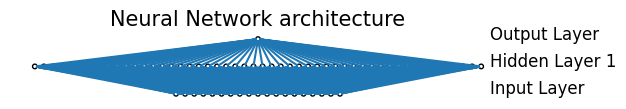

In [19]:
network = DrawNN([input_size,50,1])
network.draw()

We now have a visual representation of our Neural Network. The ``nn.Sequential`` function takes as input four functions and composes them according to the order in which they are given as arguments : ``nn.Linear(input_size,50)`` maps the ``input_size`` (i.e. 19) features of ``Hitters`` to a vector of dimension ``50``, introducing ``input_size * 50 + 50`` parameters in the model (50 weights for each of the 19 features + 50 bias terms).  

After, we compose the output with the ``nn.ReLU`` activation function, this introduces no extra parameters in the model. Similarly for the subsequent composition with a ``nn.Dropout(0.4)`` layer, which simply randomly sets $\approx$40% of the weights to 0.  

Lastly, the vector of dimension 50 is mapped to a real number (a vector of dimension 1) through the ``nn.Linear(50,1)`` function. This introduces 50 + 1 = 51 additional parameters to the model (1 weight for each of the 50 components + 1 bias term for the real output).  

If we count everything we find that the total number of parameters is equal to $19\times 50 + 50 + 50 + 1 = 1051$. Thankfully, we can use the ``torchinfo`` package to get all this information in an easier way

In [20]:
summary(hit_model, input_size=X_train.shape, col_names=['input_size',
                                                     'output_size',
                                                     'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

####Training our Neural Network :
We now have a nice Neural Network architecture, but we need to find the parameters which are going to minimize the error. In other, we need to *train* the model.  

We start by putting the data in a format that can be processed by ``torch``. The datatype that is typically handled in PyTorch is a ``tensor``. Note that all floating numbers in a tensor are 32-bit by default, instead of the 64-bit used in ```numpy``, hence we will need to convert all floats to their 32-bit counterpart before converting to tensors.

In [21]:
#converting the training data
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, Y_train_t)

#converting the testing data
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t)

Now that the data has been converted to a format that can be handled by ``torch``, we pass it through what is called a ``Dataloader()``. This helper function helps us distribute the data to the different processes in our device (CPU, GPU...) in a way that is as efficient as possible. This might seem complicated, but when dealing with datasets with samples sizes, input dimensions and number of parameters $\gg 10^6$, this is *VERY* helpful.  

We skip the details, but ``ISLP`` nicely comes with a ``SimpleDataModule()`` helper function which will streamline the data loading process :

In [22]:
#number of processes that can be used on our device to train the model
max_num_workers = rec_num_workers()

#dataloading made easier
hit_dm = SimpleDataModule(hit_train, hit_test, batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=hit_test)

Now that the data is loaded to our device, we can proceed to train ! We will use ``SimpleModule.regression()`` to indicate that we are minimizing the squared-error loss, and we will also track the evolution of the MAE as we keep optimizing the model's parameter.  

We will use ``CSVLogger()`` to store the results of our training into a ``.csv`` file. That way we will be able to load them into a Pandas dataframe which we will bea ble to easily visualize.

In [23]:
hit_module = SimpleModule.regression(hit_model, metrics={'mae':MeanAbsoluteError()})
hit_logger = CSVLogger('logs', name='hitters')

We can (finally) train our model and log the results, by calling the ``Trainer()`` object from ``pytorch_lightning``. **Task :** read the documentation and explain what each argument of ``Trainer()`` in the code below does.

In [24]:
hit_trainer = Trainer(deterministic=True, max_epochs=50,
                      log_every_n_steps=5,
                      logger=hit_logger,
                      callbacks=[ErrorTracker()])

hit_trainer.fit(hit_module , datamodule=hit_dm) #train the model !

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | HittersModel | 1.1 K 
1 | loss  | MSELoss      | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Now that we have trained our model, we can evaluate its performance on testing data :

In [25]:
hit_trainer.test(hit_module , datamodule=hit_dm)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      104098.5703125       │
│         test_mae          │    229.50115966796875     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 104098.5703125, 'test_mae': 229.50115966796875}]

Since we stored all the training information into a CSV file, we can now plot the evolution of the MAE as a function of the number of training epochs.  

In accordance with what we've previously specified, the data is stored in the ``logs/hitters`` directory and is accessible through the ``experiment.metrics_file_path`` attribute of our data logger.  

We will define a helper function to plot the results, which we will be able to reuse later.

In [26]:
#helper plotting function
def summary_plot(results , ax, col='loss', valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column, color, label) in zip([f'train_{col}_epoch', f'valid_{col}'],
                                       ['black', 'red'],
                                       [training_legend , valid_legend]):

        results.plot(x='epoch', y=column, label=label, marker='o', color=color,
                     ax=ax)

    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

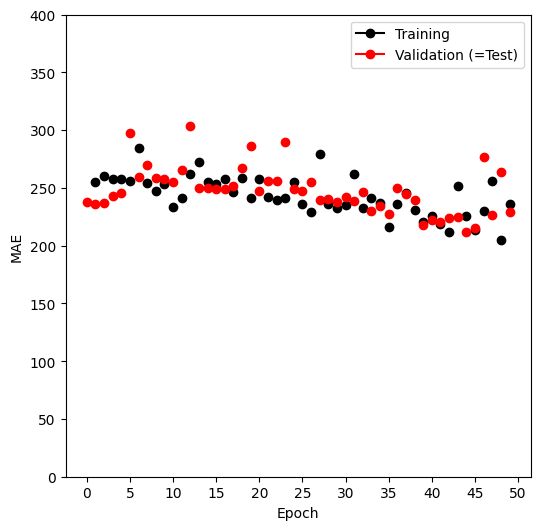

In [27]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(hit_results, ax, col='mae', ylabel='MAE',
                  valid_legend='Validation (=Test)')
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int))

Finally, we can evaluate the trained model on new data by using the ``eval()`` method, which tells ``torch`` that the model is already fitted and thus makes it disable the ``dropout`` layer (so it won't randomly set some weights to 0).

In [28]:
hit_model.eval()
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(229.5012, grad_fn=<MeanBackward0>)

####Cleanup :
Now that we have successfully trained our model, an important step remains : we have allocated several resources and worker processes to training, and unless we explictly tell them to stop, they won't stop running (basically they will stay on "standby" and will be waiting for a call from ``torch`` for them to run a training process) and will use resources on our machine !  

Hence we call the ``del`` function and delete all references to torch objects to ensure that all processes will be killed.

In [29]:
del(Hitters,
    hit_model , hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    hit_trainer, hit_module)

**Great, we have officially created our first Neural Network model. That was a lot of work, wasn't it ?**  

**Task :** Based on this first use case, would you recommend using a Neural Network to perform regression on this dataset ? (discuss based on, e.g. the number of parameters of each model, the fitting/training time in each case, the feasibility of cross-validation, the interpretability etc...)

##II - Classification : Multilayer Network on the MNIST Digit data

After having looked at a "simple" regression problem, let's see how Neural Networks classifiers perform on the classical handwritten digits MNIST dataset. The task to perform is as follows : for a given handwritten digit, represented by a $28\times28$ pixel image, accurately determine which digit (i.e. $0,1,\ldots,9$) it is.  

Formally, this can be framed as solving an multiclass classification problem where the input data lives in $\mathbb R^{28\times28}$ and the output classes live in $\{0,1,\ldots,9\}$.

###Loading the data

The MNIST dataset is available as part of the ``torchvision`` package : we will call the ``MNIST()`` function from ``torchvision.datasets`` which will download the dataset and store it in the ``data/MNIST`` directory.

In [30]:
from torchvision.datasets import MNIST
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)

In [31]:
(mnist_train, mnist_test) = [MNIST(root='data', train=train, download=True,
                             transform=ToTensor()) for train in [True , False]]

mnist_train

100%|██████████| 9912422/9912422 [00:00<00:00, 146204416.28it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 79694535.41it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 159923491.65it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16158209.30it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

There are 60,000 images in the training data and 10,000 in the test data.
The images are 28 × 28, and stored as a matrix of pixels. We need to
transform each one into a vector.

Because Neural Networks, just like other regression models such as ridge or lasso, are sensitive to the scale of the inputs (here each pixel is a grayscale number between $0$ and $255$), we need to normalize the inputs to remain between $0$ and $1$.  

Again, the ISLP-provided ``SimpleDataModule()`` provides us with a simple way to do that, while setting apart $20\%$ of the data for validation purposes

In [32]:
mnist_dm = SimpleDataModule(mnist_train, mnist_test , validation=0.2,
                            num_workers=max_num_workers, batch_size =256)

Let's have a more detailed look at what exactly will be the input of our network. The following code gives us the exact dimensionality of the first two batches of data :

In [33]:
for idx , (X_ ,Y_) in enumerate(mnist_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


We see that for each batch, the input ``X`` consists of 256 images of size ``1*28*28`` (here the first ``1`` highlights that it is a grayscale image, as opposed to a RGB image for which the ``1`` would be replaced by a ``3``), while the output ``Y`` is a vector of 256 numbers, where each component is the digit associated to the corresponding image.  

We can visualize some of those images in the training set for reference.

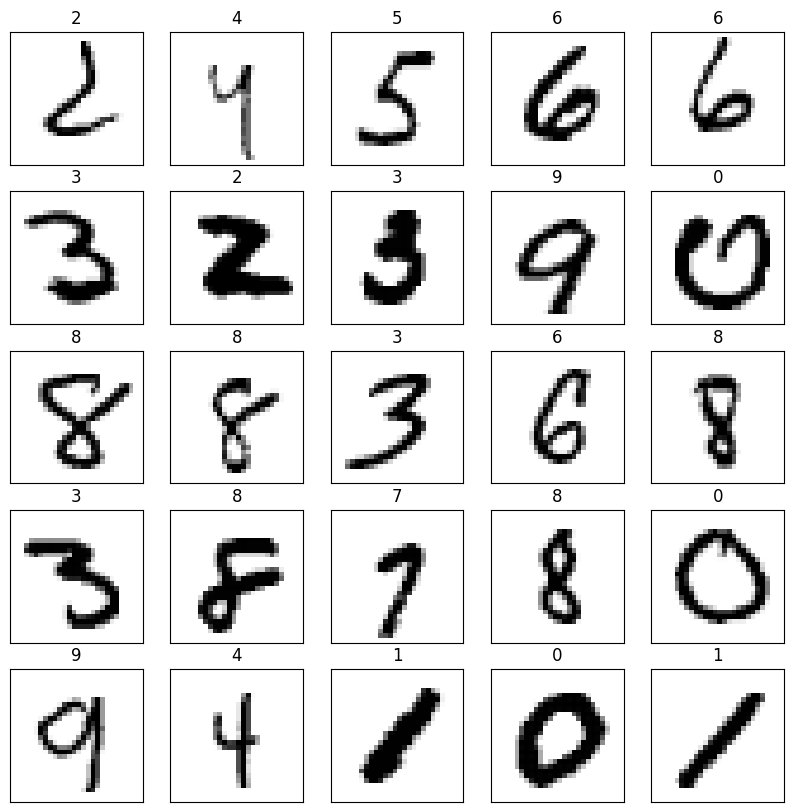

In [35]:
fig, axes = subplots(5, 5, figsize=(10,10))
rng = np.random.default_rng(4)
indices = rng.choice(np.arange(len(mnist_train)), 25,
                     replace=False).reshape((5,5))
for i in range(5):
    for j in range(5):
        idx = indices[i,j]
        axes[i,j].imshow(torch.reshape(mnist_train[idx][0],
                                      (28,28)),
                                      interpolation=None,
                                      cmap="gray_r")
        axes[i,j].set_title(str(mnist_train[idx][1]))
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

###Setting up the Neural Network architecture :

In [36]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel , self).__init__()

        self.layer1 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 256),
        nn.ReLU(),
        nn.Dropout (0.4))

        self.layer2 = nn.Sequential(
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout (0.3))

        self._forward = nn.Sequential(
        self.layer1 ,
        self.layer2 ,
        nn.Linear(128, 10))

    def forward(self , x):
        return self._forward(x)

**Task :** Describe the action of each layer of this Neural Network. Compute by hand the number of parameters it has. Which numerical values can be changed in each of the calls of ``nn.Linear()`` above while still giving a valid classifier from $\mathbb R^{28\times28}$ to $\{0,1,\ldots,9\}$ ?

Again, we can visualize the above architecture as follows

In [ ]:
#run this yourself and see what you get

#network = DrawNN([28*28,256,128,10])
#network.draw()

We can now instantiate the model and, as a sanity check, use our sample batch data to check that the output has the correct dimensions.

In [37]:
mnist_model = MNISTModel()
mnist_model(X_).size()

torch.Size([256, 10])

And a summary can be helpful, as always

In [38]:
summary(mnist_model, input_data=X_, col_names=['input_size',
                                               'output_size',
                                               'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

###Training the model

Now that we have loaded the data and specified the model, the fitting/training procedure is essentially the same as what we've done for the ``Hitters`` data. The main difference being that we will now call the ``SimpleModule.classification()`` method which will minimize the cross-entropy loss function instead of the MSE

In [39]:
mnist_module = SimpleModule.classification(mnist_model, num_classes=10)
mnist_logger = CSVLogger('logs', name='MNIST') #log the data in a .csv file

In [40]:
#specify the training options
mnist_trainer = Trainer(deterministic=True,
                        max_epochs=30,
                        logger=mnist_logger,
                        callbacks=[ErrorTracker()])

mnist_trainer.fit(mnist_module , datamodule=mnist_dm) #train the model !

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | MNISTModel       | 235 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Let's use our ``summary_plot()`` function to display accuracy across epochs :

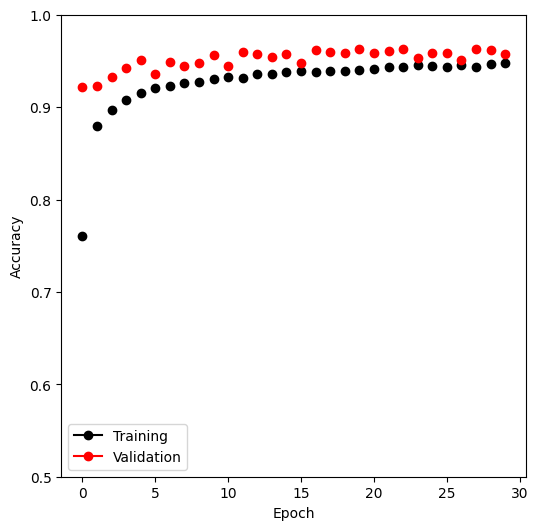

In [41]:
mnist_results = pd.read_csv(mnist_logger.experiment.metrics_file_path)
fig , ax = subplots(1, 1, figsize=(6, 6))

summary_plot(mnist_results, ax, col='accuracy',ylabel='Accuracy')

ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int))

And let's also evaluate the accuracy using the ``test()`` method of our trainer :

In [42]:
mnist_trainer.test(mnist_module, datamodule=mnist_dm)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9599000215530396     │
│         test_loss         │    0.16808855533599854    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.16808855533599854, 'test_accuracy': 0.9599000215530396}]

We see that our model reaches 96% accuracy, which is seemingly quite good !

As we did for the regression model, we might want to see how our Neural Network model compares to a simpler method such as Linear Discriminant Analysis (if you don't remember what that is, review the previous Lab/Lecture on classification).  

To fit a LDA model to the MNIST dataset, we could use the ``LogisticRegression()`` function from ``sklearn``, but observe that this is exactly equivalent to fitting a Neural Network with no hidden layers using ``torch`` !

In [43]:
class MNIST_MLR(nn.Module):
    def __init__(self):
        super(MNIST_MLR , self).__init__()
        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784, 10))

    def forward(self , x):
        return self.linear(x)

mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model, num_classes=10)
mlr_logger = CSVLogger('logs', name='MNIST_MLR')

In [ ]:
mlr_trainer = Trainer(deterministic=True ,
                      max_epochs=30,
                      callbacks=[ErrorTracker()])

mlr_trainer.fit(mlr_module , datamodule=mnist_dm) #fit the logistic regression

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | MNIST_MLR        | 7.9 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Now that we've fit the LDA model, we can test it and evaluate its performance

In [ ]:
mlr_trainer.test(mlr_module, datamodule=mnist_dm)

So the LDA model gives an accuracy of 92% which is also pretty great, while requiring 30 times less parameters !!

**Task :** based on our results, discuss the relevance/interest of using a Neural Network for this task. In general, in which kind of context do you think a Neural Network will be a better option than the other techniques we've seen in this course ?  

**Task :** Experiment by changing the Neural Network dimensions, number of layers, dropout strength etc... and see how the resulting model/training time changes.

We are now done. As before, we delete all ``torch`` initiated variables to kill all processes that were allocated for training the models.

In [ ]:
del(mnist_test ,
    mnist_train,
    mnist_model,
    mnist_dm,
    mnist_trainer,
    mnist_module,
    mnist_results,
    mlr_model,
    mlr_module,
    mlr_trainer)

### A possible fix : dimensionality reduction

We've seen that although Neural Networks perform better than all previously seen methods, they take a *long* time to be trained and typically contain a *lot* more parameters relative to the gain in accuracy/performance, which makes them unattractive for the tasks we've seen today.  

One reason why Neural Networks for image data require so many parameters is simply the data itself : for MNIST, the input is $28\times 28 =784$-dimensional, hence if we add one or two hidden layers of size comparable to that of the input we can easily get close to a million of parameters, which will be very costly to train !  

We thus see that *input data dimension* is highly correlated with number of paramters and thus computations needed to fit the model. This suggests that *reducing the dimension of the input data* could be a good way to enjoy the Neural Network improved performance for an acceptable computational cost !  

This leads us to our last (quite demanding) **Task :** Implement a dimensionality reduction method of your choice and apply it to the MNIST data. Train a neural network to fit this data and use cross-validation to choose the best number of Principle Components. Compare the training time and accuracy difference for the two models.

###IV - Conclusion

The take away message from this lab is that **neural networks are not magic wands**, they are *not* suitable for all problems and they are costly to use ! Typically, they are reserved for very complex tasks with very high-dimensional features, and in settings where we have access to a lot of computational resources.  

To learn more about Neural Networks implementation with PyTorch and go further than the two example seen today, here are some resources :

*   Chapter 10 of the book on which this lab is based on : https://www.statlearning.com/
*   Pytorch official tutorials : https://pytorch.org/tutorials/beginner/basics/intro.html, https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html, https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
*   Pytorch tutorial on kaggle : https://www.kaggle.com/code/kanncaa1/pytorch-tutorial-for-deep-learning-lovers

As is often the case in computing, the best way to learn is to play with the concepts yourself, so you are encouraged to find a project you're interested in and trying to solve it using the machine learning tools we've discussed to perfect your understanding.